In [1]:
import os
os.chdir('hotdog/')

In [2]:
from dataloader import *
import torch.nn.functional as F
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn


In [3]:
data_train = HotdogDataset()
data_test = HotdogDataset(train=False)

ValueError: If degrees is a single number, it must be positive.

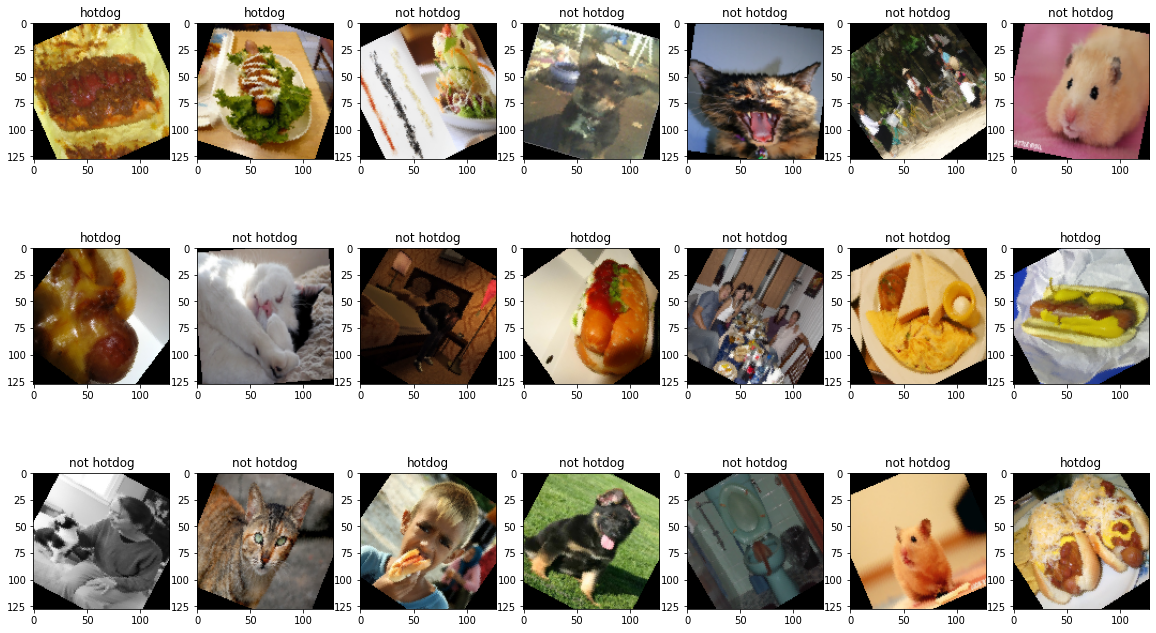

In [ ]:
images, labels = next(iter(data_train.get_dataloader(batch_size=21, shuffle=True)))
plt.figure(figsize=(20,20))
for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy().transpose(1,2,0))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])


In [ ]:
len(data_train)

2047

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [ ]:
images

tensor([[[[0.7098, 0.7333, 0.7529,  ..., 0.0118, 0.0118, 0.0118],
          [0.7098, 0.7294, 0.7451,  ..., 0.0078, 0.0078, 0.0118],
          [0.7255, 0.7412, 0.7490,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.2353, 0.2510, 0.2431,  ..., 0.0157, 0.0196, 0.0157],
          [0.2039, 0.2157, 0.2235,  ..., 0.0157, 0.0157, 0.0157],
          [0.1765, 0.1843, 0.1804,  ..., 0.0157, 0.0157, 0.0157]],

         [[0.6627, 0.6745, 0.6941,  ..., 0.0118, 0.0118, 0.0118],
          [0.6588, 0.6706, 0.6863,  ..., 0.0078, 0.0078, 0.0118],
          [0.6706, 0.6784, 0.6784,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.2275, 0.2431, 0.2510,  ..., 0.0157, 0.0196, 0.0157],
          [0.2078, 0.2118, 0.2196,  ..., 0.0157, 0.0157, 0.0157],
          [0.1765, 0.1725, 0.1686,  ..., 0.0157, 0.0157, 0.0157]],

         [[0.6706, 0.6863, 0.6980,  ..., 0.0039, 0.0039, 0.0039],
          [0.6706, 0.6824, 0.6902,  ..., 0.0000, 0.0039, 0.0078],
          [0.6824, 0.6902, 0.6902,  ..., 0

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
            # 3 channels as input -- Colored images
            # out channels arbritrarily set
            # kenel is (5x5)
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            # 2x2 reduction and stride 2 -- We move 2 pixels every time
            nn.MaxPool2d(2,2),
            # input size must mach previous output size.
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU()

        )

        self.fully_connected = nn.Sequential(
            # output size from conv layer is calculated below
            nn.Linear(in_features=16*69*69, out_features=120),
            nn.Linear(in_features=120, out_features=60),
            nn.Linear(in_features=60, out_features=2),
            nn.Softmax(dim = 1)
        )

    
    def forward(self, x):
        x = self.convolutional(x)
        #print(x.size())
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x
     


In [ ]:
## Network 2
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, out_channels = 64,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.3)

        )

        self.fully_connected = nn.Sequential(
            # output size from conv layer is calculated below
            nn.Linear(64, out_features=128),
            nn.Linear(128, out_features=64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    
    def forward(self, x):
        x = self.convolutional(x)
        #print(x.size())
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x
     


In [ ]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# Expand data
train_loader = data_train.get_dataloader()
test_loader = data_test.get_dataloader()
#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
#Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
#model(data); #if this runs the model dimensions fit

RuntimeError: running_mean should contain 64 elements not 128

In [ ]:
num_epochs = 5

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    model.train()
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    model.eval()
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(data_train)
    test_acc = test_correct/len(data_test)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
     


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Accuracy train: 54.7%	 test: 61.3%


  0%|          | 0/64 [00:00<?, ?it/s]

Accuracy train: 56.1%	 test: 44.6%


  0%|          | 0/64 [00:00<?, ?it/s]

Accuracy train: 51.8%	 test: 48.1%


  0%|          | 0/64 [00:00<?, ?it/s]

Accuracy train: 55.0%	 test: 69.4%


  0%|          | 0/64 [00:00<?, ?it/s]

Accuracy train: 54.4%	 test: 49.9%
